In [1]:
import xarray
import numpy
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# graphics style
plt.style.use(r"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/style_files/presentation_matplotlibrc.template")

## Functions
1. Reshape FVCOM array (reshape_fvcom)
2. Extract model output by depth level (extract_fvcom_level)

In [3]:
# function to reshape FVCOM array
def reshape_fvcom(fvcom_timeIJK, reshape_type):
    """ Reorganize the 2D FVCOM output from 2-dimensions of (time,nodes)
    to a format that allows for daily, yearly, or depth calculations. 
    
    param float fvcom_timeIJK: FVCOM_v2.7ecy output array in dimension of 8760x160120.
    param string reshape_type: ['days','levels','dayslevels']
    return: Reorganized array
    """
    ti,ni = fvcom_timeIJK.shape
    print(ti,ni)
    # Error handling
    if reshape_type not in ['days','levels','dayslevels']:
        raise ValueError(
            "options for reshape_type are: 'days','levels','dayslevels'"
        )
    
    # Reshaping
    if reshape_type == 'days':
        if (ti != 8760):
            raise TypeError(
                "FVCOM array must have a time dimension of 8760"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,ni)
        )
    elif reshape_type == 'levels':
        if (ni != 160120):
            raise TypeError(
                "FVCOM array must have a node dimension of 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (ti,16012,10)
        )
    elif reshape_type == 'dayslevels':
        if (ti != 8760) or (ni != 160120):
            raise TypeError(
                "FVCOM array size must be 8760 x 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,16012,10)
        )
        
    return fvcom_reshaped

In [4]:
def extract_fvcom_level(gdf, fvcom_timeIJK, LevelNum):
    """ Extract model output at nodes by level. 
    
    param dataframe gdf: geopandas dataframe of FVCOM nodes from 2D planar nodes
        with dimensions of 16012.
    param float fvcom_timeIJK: 3D-FVCOM output in dimensions of time x 160120.
    param int LevelNum: Integer from 1 (surface) to 10 (bottom)
    
    return fvcom_nodeIDs: model output at level in dimension of time x 16012
    """
    if LevelNum not in range(1,11):
        raise ValueError("fvcom_LevelNum must be an integer value from 1-10")

    try:
        node_ids = gdf['node_id'].to_numpy()
    except:
        raise AttributeError("missing 'node_id' column in dataframe")
        
    ijk_index = node_ids * 10 - (11-LevelNum)
    # get DO values at each level
    fvcom_nodeIDs = fvcom_timeIJK[:,ijk_index]
    # if ds['Var_10'] is passed in: 
    # fvcom_nodeIDs = fvcom_timeIJK[:,:].data[:,ijk_index]
    
    return fvcom_nodeIDs

In [5]:
def calc_fvcom_stat(fvcom_output, stat_type, axis):
    """ Extract model output at nodes by level. 
    
    param float fvcom_output: FVCOM_v2.7ecy output array in dimensions of time x 160120.
    param float stat_type: 'min','mean'.
    param int axis: Integer from 0 to ndims(fvcom_output)
    
    return: stat of model output across specified axis (axs)
    """
    fvcom_stat = getattr(numpy,stat_type)(fvcom_output,axis=axis)
    
    return fvcom_stat

## Definitions

In [6]:
# Create a dictionary with all variable options (these can be expanded)
variable_name_list=['DO','NH3','NO3','NPP','Temp','Salinity']
parameter_ID_list=['Var_10','Var_14','Var_15','Var_17','Var_18','Var_19']
model_output_name = {
    variable_name_list[i]: parameter_ID_list[i] for i in range(len(variable_name_list))
}

# Define the variable that we want to plot
variable_name = "DO" 

# Define directory for saving netcdf output
output_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/output/daily_min')

# Define locations for different scenarios
root_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/')
data_paths=numpy.array(
    [root_dir/'2014_SSM4_WQ_exist_orig/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_ref_orig/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr0.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr_ref_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr_mgt_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist0.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC2.0/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC1.5/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC0.5/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC0.0/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_North/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_CN/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_Central/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_Nth_wC/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_Ctl_wC/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_CN_wC/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp_3mgl_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp0.5_reg/hotstart/outputs'
    ]
)    

## Get min daily DO

In [7]:
si = 0 # choose first directory = Existing
variable_name = 'DO'

In [8]:
scenario_name=str(data_paths[si]).split('/')[-3]
# output netcdf filename
output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
# input netcdf filename
file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
# load variable into xarray and calculate daily min.
with xarray.open_dataset(file_path) as ds:
    dailyDO = reshape_fvcom(
        ds[model_output_name[variable_name]][:,:].data, 
        'days'
    ) #return (365x24xnodes)
    # calculate daily minimum
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # calculate minimum across depth levels
    dailyDO_tmin_zmin = calc_fvcom_stat(dailyDO_tmin_rshp, 'min', axis=2)

8760 160120
365 160120


In [9]:
## Number of days with min DO difference < 2
daily_minDO={}
# save Existing
daily_minDO['exist']=dailyDO_tmin_zmin

In [10]:
ds[model_output_name['DO']].attrs['FVCOM_Name']

'Conc. of DO mg/l'

In [11]:
dailyDO_tmin_zmin.shape

(365, 16012)

#### Plot 3-panel graphic of
- minimum daily DO and across depth
- minimum daily DO at bottom
- difference

In [12]:
# Get nodes

# #Ben's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/ssm-analysis/gis'
)/'ssm filled domain nodes.shp'
gdf_b = gpd.read_file(shapefile_path)
gdf_b.head(2)

,node_id,depth,geometry
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."


In [13]:
# Kevin's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/shapefiles'
)/'SSMGrid2_tce.shp'
gdf_k = gpd.read_file(shapefile_path)
gdf_k = gdf_k.loc[:, ('tce','Basin','geometry')]
gdf_k=gdf_k.rename(columns={'tce':'node_id'})
gdf_k.head(2)

,node_id,Basin,geometry
0,1249,SJF_Admiralty,"POLYGON ((-13875002.725 6177241.606, -13875563..."
1,1336,SJF_Admiralty,"POLYGON ((-13871902.847 6172073.657, -13872526..."


In [14]:
gdf_k.head(2)

,node_id,Basin,geometry
0,1249,SJF_Admiralty,"POLYGON ((-13875002.725 6177241.606, -13875563..."
1,1336,SJF_Admiralty,"POLYGON ((-13871902.847 6172073.657, -13872526..."


In [15]:
gdf_k[['node_id','Basin']].groupby('Basin').count().rename(columns={'node_id':'node count'})

,node count
Basin,
Hood Canal,726
Main Basin,1208
SJF_Admiralty,958
SOG_Bays,743
South Sound,1722
Whidbey_Basin,2067


In [16]:
# Extract SOG_Bays from Kevin's shapefile 
gdf_SOG_Nbays = gdf_k.loc[gdf_k['Basin']=='SOG_Bays']
gdf_SOG_Nbays.shape

(743, 3)

In [17]:
# Compare South Sound "tce" to Ben's "node_id"
gdf_ssound = gdf_k.loc[gdf_k['Basin']=='South Sound']
print(gdf_ssound['node_id'].min(),gdf_ssound['node_id'].max(),gdf_b['node_id'].min(),gdf_b['node_id'].max())

13544 16012 4369 16012


### Plot up min DO below Threshold for SOG & North Bays

In [18]:
gdf = gdf_SOG_Nbays.copy()
gdf.shape

(743, 3)

In [50]:
# define min DO threshold
threshold=4
dailyDO_tmin_zmin_lt_thresh=numpy.count_nonzero(dailyDO_tmin_zmin<threshold,axis=0)
# use node_id to select locations
dailyDO_tmin_zmin_lt_thresh_SOG = dailyDO_tmin_zmin_lt_thresh[gdf['node_id']-1]
dailyDO_tmin_zmin_lt_thresh_SOG.shape

(743,)

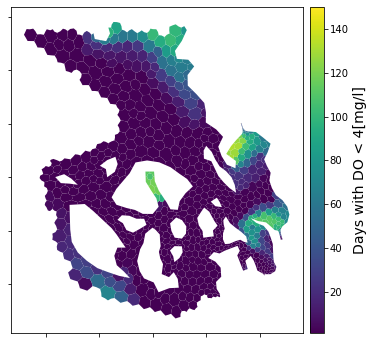

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
gdir = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/dev/minDO/')
fs_t=14
fs_a=12
cax={}
gdf['DOlt5'] = dailyDO_tmin_zmin_lt_thresh_SOG   
fig, axs = plt.subplots(1,1, figsize = (8,6))
# create `cax` for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot('DOlt5', ax=axs, cax=cax, legend=True,vmin=1, vmax=150)
cax.set_ylabel(f'Days with DO < {threshold}[mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
plt.savefig(gdir/f'SOGNB_minDO_lt{threshold}.jpeg',dpi=150)
plt.show()

In [22]:
si = 1 # choose first directory = Existing
variable_name = 'DO'
scenario_name=str(data_paths[si]).split('/')[-3]
# output netcdf filename
output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
# input netcdf filename
file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
# load variable into xarray and calculate daily min.
with xarray.open_dataset(file_path) as ds:
    dailyDO = reshape_fvcom(
        ds[model_output_name[variable_name]][:,:].data, 
        'days'
    ) #return (365x24xnodes)
    # calculate daily minimum
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # calculate minimum across depth levels
    dailyDO_tmin_zmin = calc_fvcom_stat(dailyDO_tmin_rshp, 'min', axis=2)
daily_minDO['ref']=dailyDO_tmin_zmin 
daily_minDO['diff']=daily_minDO['exist']-daily_minDO['ref']


8760 160120
365 160120


In [55]:
# SOG
gdf = gdf_SOG_Nbays.copy()

daily_minDO['diff_count']=numpy.count_nonzero((daily_minDO['exist']-daily_minDO['ref'])<-0.25,axis=0)
# use node_id to select locations
daily_minDOdiff_SOG = daily_minDO['diff_count'][gdf['node_id']-1]
daily_minDOdiff_SOG.shape

(743,)

In [56]:
daily_minDOdiff_SOG.max()

56

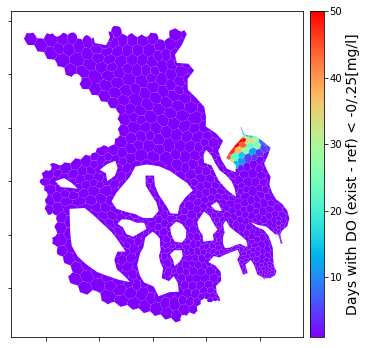

In [57]:
cax={}
gdf['DOdiff'] = daily_minDOdiff_SOG   
fig, axs = plt.subplots(1,1, figsize = (8,6))
# create `cax` for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot('DOdiff', ax=axs, cax=cax, legend=True,vmin=1, vmax=50,cmap='rainbow')
cax.set_ylabel(f'Days with DO (exist - ref) < -0/.25[mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
plt.savefig(gdir/f'SOGNB_minDO_Exist_minus_Ref_ltm0p25.jpeg',dpi=150)
plt.show()

In [52]:
# PS
gdf = gdf_b.copy()

daily_minDO['diff_count']=numpy.count_nonzero((daily_minDO['exist']-daily_minDO['ref'])<-0.25,axis=0)
# use node_id to select locations
daily_minDOdiff_SOG = daily_minDO['diff_count'][gdf['node_id']-1]
daily_minDOdiff_SOG.shape

(6120,)

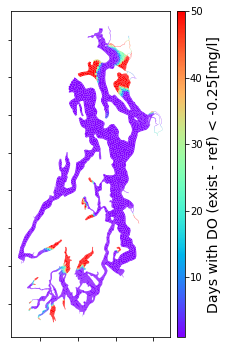

In [54]:
cax={}
gdf['DOdiff'] = daily_minDOdiff_SOG   
fig, axs = plt.subplots(1,1, figsize = (8,6))
# create `cax` for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot('DOdiff', ax=axs, cax=cax, legend=True,vmin=1, vmax=50,cmap='rainbow')
cax.set_ylabel(f'Days with DO (exist - ref) < -0.25[mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
plt.savefig(gdir/f'PS_minDO_Exist_minus_Ref_lt_m0p25.jpeg',dpi=150)
plt.show()

### Plot 3-panel of min bottom DO, min DO across depth and difference

In [22]:
DO={}
# change name so that I can replicate this code more easily
gdf = gdf_SOG_Nbays.copy()

# the min across depth ought to have same node index as the shapefile
DO['minDailyLevels'] = dailyDO_tmin_zmin[:,gdf['node_id']-1]
# we need to map the nodes with all depths included to the shapefile nodes
DO['minDailyBottom'] = extract_fvcom_level(gdf, dailyDO_tmin, LevelNum=10)
DO['difference'] = DO['minDailyLevels'] - DO['minDailyBottom']

In [23]:
# ## Some code to do colorbars properly
# # create the colorbar
# norm = colors.Normalize(vmin=0, vmax=1)
# cbar = plt.cm.ScalarMappable(norm=norm, cmap='gist_earth_r')

# # plot
# fig, ax = plt.subplots(figsize=(15, 7))
# gdf.plot(column='Index_power', cmap='gist_earth_r', legend=False, norm=norm, ax=ax) 

# # add colorbar
# ax_cbar = fig.colorbar(cbar, ax=ax)

# Plot SOG and N. Bays using Kevin's shapefile

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


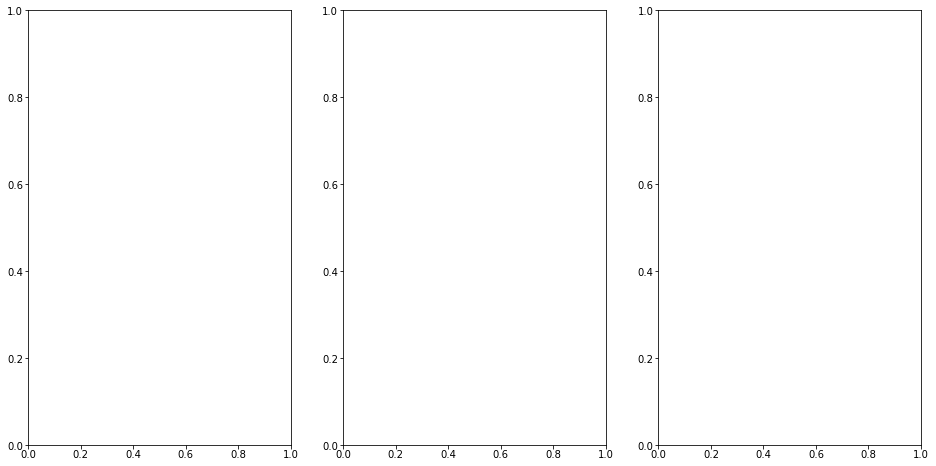

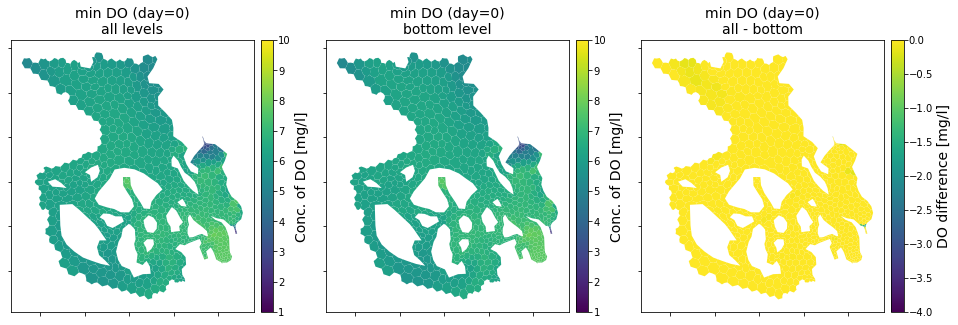

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
gdir = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/dev/minDO/SOG')
fig, axs = plt.subplots(1,3, figsize = (16,8))
fs_t=14
fs_a=12
cax={}

for time_index in range(0,1):#365):
    gdf['minDailyLevels'] = DO['minDailyLevels'][time_index]
    gdf['minDailyBottom'] = DO['minDailyBottom'][time_index]
    gdf['difference'] = DO['difference'][time_index]
    
    fig, axs = plt.subplots(1,3, figsize = (16,8))
    # create `cax` for the colorbar
    for axs_ind in range(0,3):
        divider = make_axes_locatable(axs[axs_ind])
        cax[axs_ind] = divider.append_axes("right", size="5%", pad=0.1)
        #cax[axs_ind].set_yticklabels({'fontsize': 14})
        #cax[axs_ind].set_ylabel('Conc. of DO mg/l',fontsize=14)

    gdf.plot('minDailyLevels', ax=axs[0], cax=cax[0], legend=True,vmin=1, vmax=10)
    cax[0].set_ylabel(ds[model_output_name['DO']].attrs['FVCOM_Name'],fontsize=14)
    gdf.plot('minDailyBottom', ax=axs[1], cax=cax[1], legend=True,vmin=1, vmax=10)
    cax[1].set_ylabel(ds[model_output_name['DO']].attrs['FVCOM_Name'],fontsize=14)
    gdf.plot('difference', ax=axs[2], cax=cax[2], legend=True, vmin=-4, vmax=0)
    cax[2].set_ylabel('DO difference [mg/l]',fontsize=14)
    for idx in [0,1,2]:
        axs[idx].set(yticklabels='', xticklabels='')
    axs[0].set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
    axs[1].set_title(f'min DO (day={time_index})\nbottom level', fontsize=fs_t)
    axs[2].set_title(f'min DO (day={time_index})\nall - bottom', fontsize=fs_t)
    #plt.savefig(gdir/f'{time_index:03d}.jpeg',dpi=150)
    plt.show()

# Plot S. Sound using Ben's shapefile

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


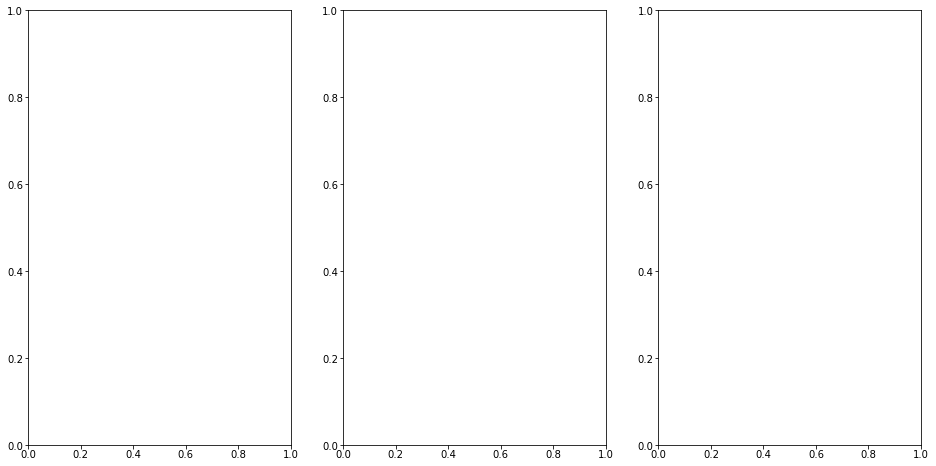

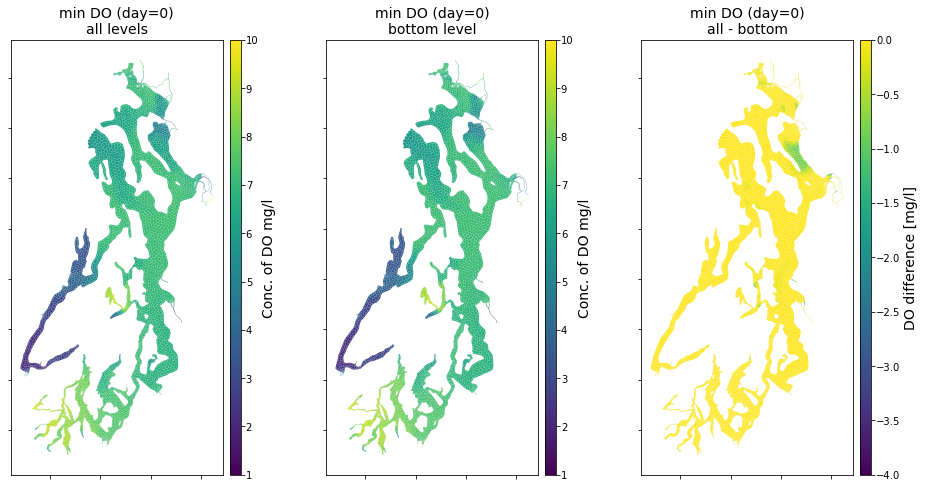

In [20]:
gdf = gdf_b.copy()
DO={}

# the min across depth ought to have same node index as the shapefile
DO['minDailyLevels'] = dailyDO_tmin_zmin[:,gdf['node_id']-1]
# we need to map the nodes with all depths included to the shapefile nodes
DO['minDailyBottom'] = extract_fvcom_level(gdf, dailyDO_tmin, LevelNum=10)
DO['difference'] = DO['minDailyLevels'] - DO['minDailyBottom']
from mpl_toolkits.axes_grid1 import make_axes_locatable
gdir = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/dev/minDO/PS')
fig, axs = plt.subplots(1,3, figsize = (16,8))
fs_t=14
fs_a=12
cax={}
for time_index in range(0,1):#365):
    gdf['minDailyLevels'] = DO['minDailyLevels'][time_index]
    gdf['minDailyBottom'] = DO['minDailyBottom'][time_index]
    gdf['difference'] = DO['difference'][time_index]
    
    fig, axs = plt.subplots(1,3, figsize = (16,8))
    # create `cax` for the colorbar
    for axs_ind in range(0,3):
        divider = make_axes_locatable(axs[axs_ind])
        cax[axs_ind] = divider.append_axes("right", size="5%", pad=0.1)
        #cax[axs_ind].set_yticklabels({'fontsize': 14})
        #cax[axs_ind].set_ylabel('Conc. of DO mg/l',fontsize=14)

    gdf.plot('minDailyLevels', ax=axs[0], cax=cax[0], legend=True,vmin=1, vmax=10)
    cax[0].set_ylabel(ds[model_output_name['DO']].attrs['FVCOM_Name'],fontsize=14)
    gdf.plot('minDailyBottom', ax=axs[1], cax=cax[1], legend=True,vmin=1, vmax=10)
    cax[1].set_ylabel(ds[model_output_name['DO']].attrs['FVCOM_Name'],fontsize=14)
    gdf.plot('difference', ax=axs[2], cax=cax[2], legend=True, vmin=-4, vmax=0)
    cax[2].set_ylabel('DO difference [mg/l]',fontsize=14)
    for idx in [0,1,2]:
        axs[idx].set(yticklabels='', xticklabels='')
    axs[0].set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
    axs[1].set_title(f'min DO (day={time_index})\nbottom level', fontsize=fs_t)
    axs[2].set_title(f'min DO (day={time_index})\nall - bottom', fontsize=fs_t)
    #plt.savefig(gdir/f'{time_index:03d}.jpeg',dpi=150,bbox_inches='tight')
    plt.show()

    

In [51]:
print(gdf['node_id'].shape)
print(fvcom_nodeIDs.shape)
print(dailyDO_tmin_zmin.shape) # minimum over 24-hrs and all depth levels
print(dailyDO_tmin_rshp[:,:,9].shape) #bottom level

(6120,)
(365, 6120)
(365, 16012)
(365, 16012)


## Start simple: Extract information for one variable and one scenario

coded in a way that this can easily be adapted to many scenarios and variables

In [14]:
%%time
# use range to easily adapt to multiple scenarios but only select the first one here
for si in range(0, 1):
    print(data_paths[si])
    scenario_name=str(data_paths[si]).split('/')[-3]
    # output netcdf filename
    output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
    # input netcdf filename
    file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
    # load variable into xarray and calculate daily min.
    # NOTE: For ease, I use original method with numpy and pandas but 
    #    it may be worth exploring ways to calculate the min in xarray format
    with xarray.open_dataset(file_path) as ds:
        model_output_daily=numpy.reshape(
            ds[model_output_name[variable_name]][:,:].data, (365,24,160120)
        )
        model_output_daily_min=numpy.min(model_output_daily,axis=1)
        model_output_daily_min_pd=pandas.DataFrame(model_output_daily_min)
        # create a new xarray with min daily values
        model_output_daily_min_xr = xarray.DataArray(model_output_daily_min_pd)
        # rename the coordinates so they are human-readable
        model_output_daily_min_xr=model_output_daily_min_xr.rename(
            {'dim_0':'time_in_days', 'dim_1':'node_id'}
        )
        model_output_daily_min_xr.to_netcdf(output_file)
        

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_exist_orig/hotstart/outputs
CPU times: user 2.07 s, sys: 13.2 s, total: 15.2 s
Wall time: 52.8 s


### Ben's method of extracting the bottom depth values.  From his [DO ecolocy extraction.ipynb](https://github.com/bedaro/ssm-analysis/blob/main/DO%20ecology%20extraction.ipynb) notebook:

IJK is a representation of the 10 depth points per node, zero-indexed, so to get the bottom points we need to multiply the node number minus 1 by 10 and add 9. For instance, if we wanted the bottom point of node 1 we'd get IJK index 9, and for node 2 we'd get IJK index 19. This simplifies to the expression in the cell below.
```
# read in 2D nodes from shapefile
domain_nodes = gpd.read_file(domain_nodes_shp)
domain_nodes.set_index('node_id', inplace=True)
# map 2D "node_id" to 3D bottom depth "node_id"
node_ids = domain_nodes.sort_index().index.to_numpy()
ijk_index = node_ids * 10 - 1
display(ijk_index)
bottom_output = ds[model_output_name[variable_name]][:,:].data[:,ijk_index]
```
In this method, the bottom level nodes are extracted into a 1D vector 
### Su Kyong's code for reshaping output into 24-hr days and depth-layers
```
np.reshape(3D_data,(365,24,16012,10))
```
In this method, the nodes are reshaped into a matrix with dimensions 365x24x16012x10

### PROOF OF CONCEPT: plot the annually-averaged DO for each of the ten layers

In [7]:
model_output=numpy.reshape(
    ds[model_output_name['DO']][:,:].data, (365*24,16012,10)
)
model_output_yrAvg=numpy.mean(model_output,axis=0)

In [10]:
model_output_yrAvg.shape

(16012, 10)

These are the yearly-averaged values over the entire grid but Ben's shapefile is just for the Puget Sound.  

## Sample graphic (experiment with bathymetry)


In [16]:
import geopandas as gpd
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/ssm-analysis/gis'
)/'ssm filled domain nodes.shp'
gdf = gpd.read_file(shapefile_path)

In [13]:
gdf.shape

(6120, 3)

In [14]:
gdf.head(3)

,node_id,depth,geometry
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
2,4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."


### Create vectors with node_ids that will map the 3D output to the 2D shapefile node_IDs

In [ ]:
%%time
node_ids = gdf['node_id'].to_numpy()
ijk_index={}
DO={}
for depth_layer in range(1,11):
    print(depth_layer)
    DO[depth_layer]=extract_fvcom_level(
        ds[model_output_name['DO']], 
        node_ids, 
        depth_layer
    )

In [18]:
%%time
node_ids = gdf['node_id'].to_numpy()
ijk_index={}
DO={}
for depth_layer in range(1,11):
    print(depth_layer)
    ijk_index[depth_layer] = node_ids * 10 - (11-depth_layer)
    # get DO values at each level
    DO[depth_layer] = ds[model_output_name['DO']][:,:].data[:,ijk_index[depth_layer]]

1
2
3
4
5
6
7
8
9
10
CPU times: user 14 s, sys: 1min 8s, total: 1min 22s
Wall time: 6min 23s


### We have 10 depth-layers of yearly data for 6120 nodes
Take yearly-average of DO for each layer

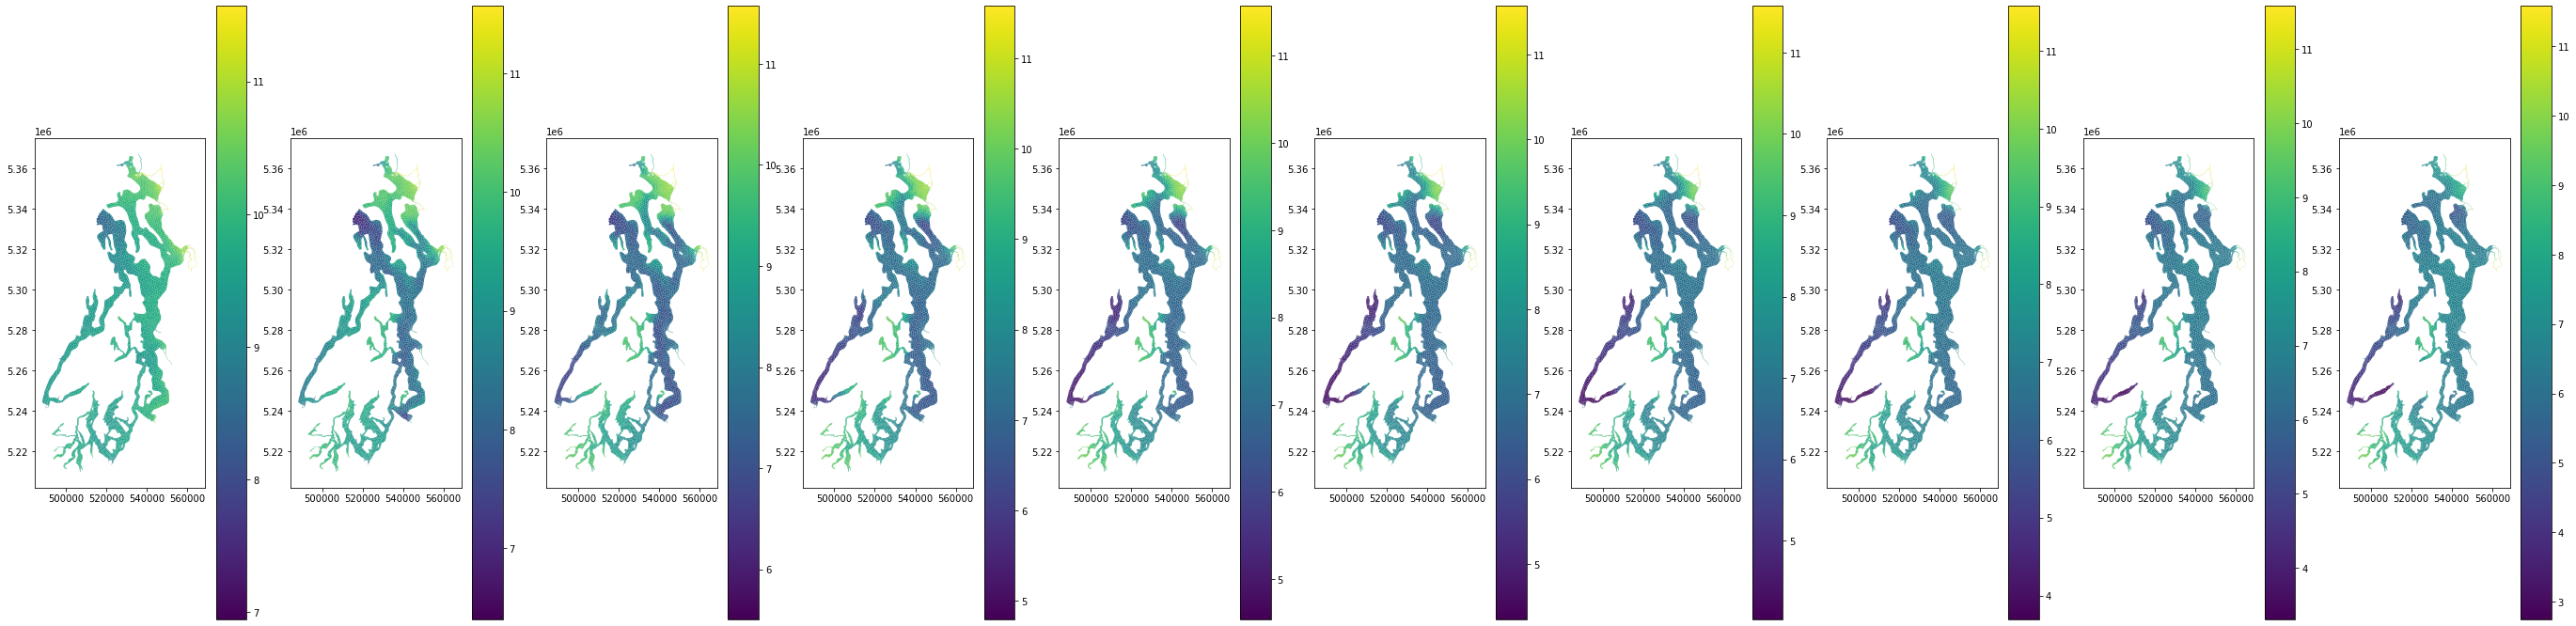

In [38]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,10, figsize = (48,8))
for level in range(1,11):
    gdf.plot(f'DO_yrAvg_lvl{level}', ax=axs[level-1], legend=True)
    axs[level-1].set(yticklabels='', xticklabels='')
    axs[level-1].set_title(f'Dissolved Oxygen\nLevel = {level}')


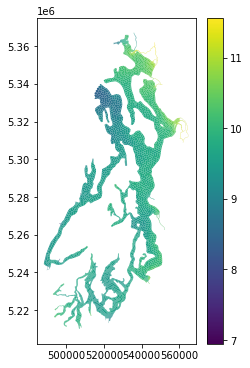

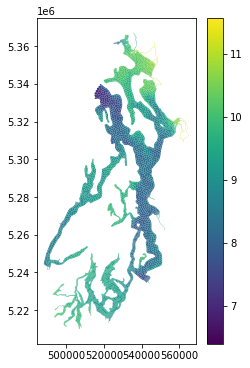

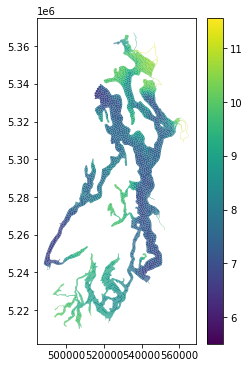

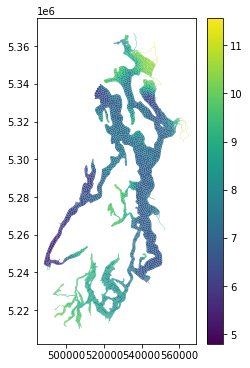

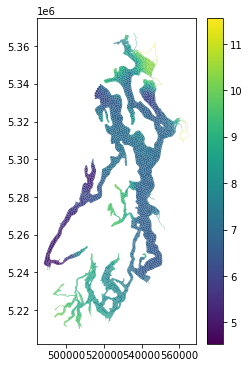

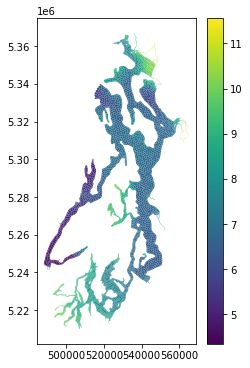

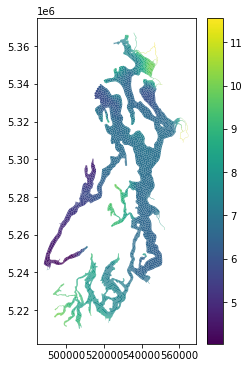

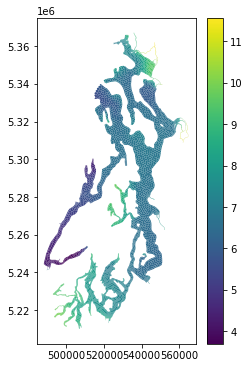

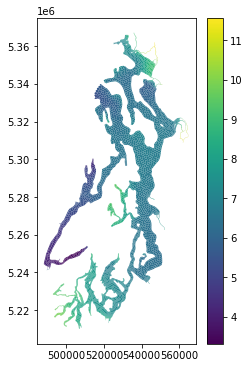

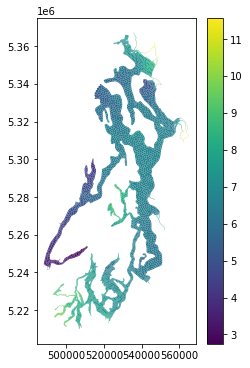

In [19]:
DO_yrAvg={}
for depth_layer in range(1,11):
    DO_yrAvg[depth_layer] = numpy.mean(DO[depth_layer],axis=0)
    gdf[f'DO_yrAvg_lvl{depth_layer}'] = DO_yrAvg[depth_layer]
    gdf.plot(f'DO_yrAvg_lvl{depth_layer}', figsize=(4,6), legend=True)

In [11]:
DO[depth_layer].shape

(8760, 6120)

<AxesSubplot:>

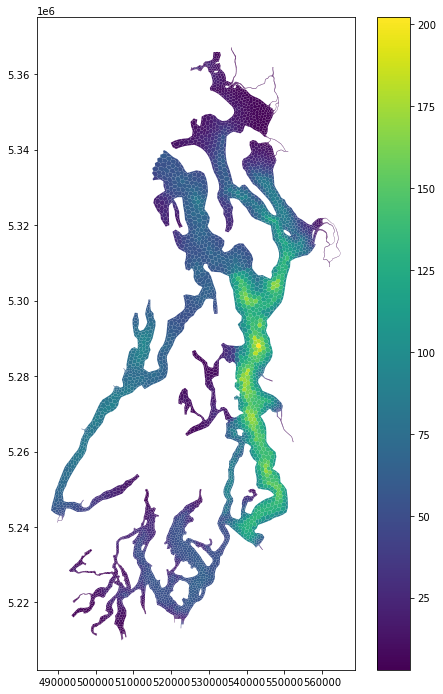

In [6]:
gdf.plot('depth', figsize=(8,12), legend=True)

In [7]:
[*gdf]

['node_id', 'depth', 'geometry']

In [8]:
len(gdf['node_id'])

6120

In [9]:
gdf['node_id'][0]

4369

In [10]:
gdf['node_id'][1]

4370

In [11]:
model_output_daily_min_xr[0].loc[model_output_daily_min_xr[0]['node_id']==gdf['node_id'][0]]

<xarray.DataArray (node_id: 1)>
array([2.75133], dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 4369

In [12]:
model_output_daily_min_xr[0]

<xarray.DataArray (node_id: 160120)>
array([9.25624, 8.97335, 8.94501, ..., 8.38638, 8.33282, 8.24202],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 0 1 2 3 4 ... 160116 160117 160118 160119

In [13]:
model_output_daily_min_xr[0]

<xarray.DataArray (node_id: 160120)>
array([9.25624, 8.97335, 8.94501, ..., 8.38638, 8.33282, 8.24202],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 0 1 2 3 4 ... 160116 160117 160118 160119

In [14]:
test = model_output_daily_min_xr[0].where((model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), drop=True)

In [15]:
test.shape

(6120,)

## Plot DO output "as is" 

## DO graphic (Extract Puget Sound DO from model output and plot)
plot `model_output_daily_min_xr`


#### use the `node_id` values in `gdf` to select DO values from model output. 

In [16]:
DO_1day = model_output_daily_min_xr[0].where(
    (model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), 
    drop=True
)
DO_1day

<xarray.DataArray (node_id: 6120)>
array([2.75133, 8.42024, 8.38708, ..., 8.79217, 8.42545, 7.42277],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 4369 4370 4371 4372 ... 16010 16011 16012

In [17]:
DO_1day.values

array([2.75133, 8.42024, 8.38708, ..., 8.79217, 8.42545, 7.42277],
      dtype=float32)

In [18]:
test = DO_1day['node_id'].to_dataframe()
test['DO']=DO_1day.values
test.pop('time_in_days')
test.pop('node_id')
test

,DO
node_id,
4369,2.75133
4370,8.42024
4371,8.38708
4372,8.34079
4373,7.04035
...,...
16008,6.49287
16009,6.49281
16010,8.79217


In [19]:
test2 = pandas.merge(
    gdf,
    test,
    how="inner",
    on=None,
    left_on='node_id',
    right_on='node_id',
)

In [20]:
test2

,node_id,depth,geometry,DO
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",2.75133
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",8.42024
2,4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",8.38708
3,4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",8.34079
4,4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",7.04035
...,...,...,...,...
6115,16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",6.49287
6116,16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",6.49281
6117,16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",8.79217
6118,16011,4.000000,"POLYGON ((498793.630 5233760.500, 498766.087 5...",8.42545


<AxesSubplot:>

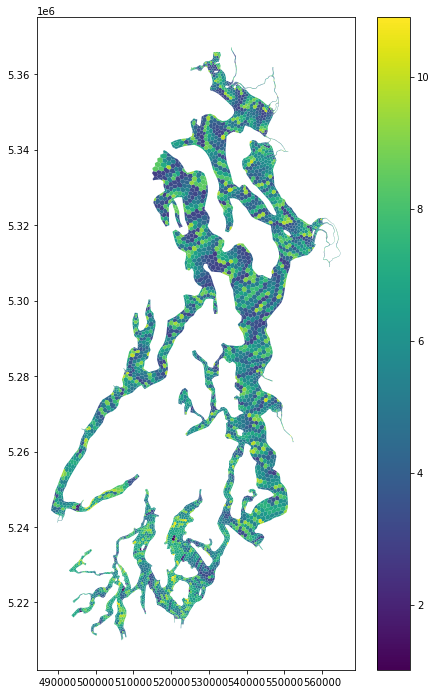

In [21]:
test2.plot('DO', figsize=(8,12), legend=True)

In [22]:
gdf['DO_1day']=DO_1day.values

<AxesSubplot:>

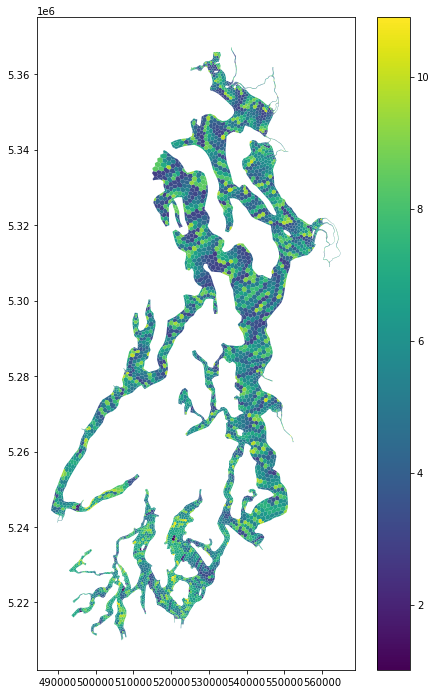

In [23]:
gdf.plot('DO_1day', figsize=(8,12), legend=True)

### Well, that didn't work.  We aren't in the business of making dragons. 

# repeat the above with mean daily values

In [48]:
%%time
# use range to easily adapt to multiple scenarios but only select the first one here
for si in range(0, 1):
    print(data_paths[si])
    scenario_name=str(data_paths[si]).split('/')[-3]
    # output netcdf filename
    output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
    # input netcdf filename
    file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
    # load variable into xarray and calculate daily min.
    # NOTE: For ease, I use original method with numpy and pandas but 
    #    it may be worth exploring ways to calculate the min in xarray format
    with xarray.open_dataset(file_path) as ds:
        model_output_daily=numpy.reshape(
            ds[model_output_name[variable_name]][:,:].data, (365,24,160120)
        )
        model_output_daily_mean=numpy.mean(model_output_daily,axis=1)
        model_output_daily_mean_pd=pandas.DataFrame(model_output_daily_mean)
        # create a new xarray with min daily values
        model_output_daily_mean_xr = xarray.DataArray(model_output_daily_mean_pd)
        # rename the coordinates so they are human-readable
        model_output_daily_mean_xr=model_output_daily_mean_xr.rename(
            {'dim_0':'time_in_days', 'dim_1':'node_id'}
        )
        # model_output_daily_min_xr.to_netcdf(output_file)
        

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_exist_orig/hotstart/outputs
CPU times: user 2.11 s, sys: 14.8 s, total: 16.9 s
Wall time: 56 s


In [49]:
ds.Var_10[:,:].shape

(8760, 160120)

<AxesSubplot:>

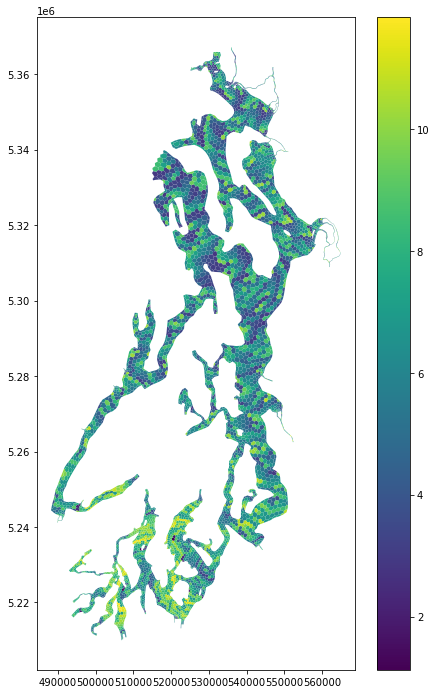

In [50]:
# Get DO values for all nodes in gdf['node_id']
DO_1day = model_output_daily_mean_xr[0].where(
    (model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), 
    drop=True
)
# create dataframe
df={}
df['mean'] = DO_1day['node_id'].to_dataframe()
df['mean']['DO']=DO_1day.values
df['mean'].pop('time_in_days')
df['mean'].pop('node_id')
# merge model output with shapefile using "node_id" for merge
gdf_merged = pandas.merge(
    gdf,
    df['mean'],
    how="inner",
    on=None,
    left_on='node_id',
    right_on='node_id',
)
gdf_merged.plot('DO', figsize=(8,12), legend=True)

In [36]:
df['mean']

,DO
node_id,
4369,2.724172
4370,8.791427
4371,8.079263
4372,7.007764
4373,5.671616
...,...
16008,6.088748
16009,5.883926
16010,9.565045


In [37]:
gdf

,node_id,depth,geometry,DO_1day
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",2.75133
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",8.42024
2,4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",8.38708
3,4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",8.34079
4,4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",7.04035
...,...,...,...,...
6115,16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",6.49287
6116,16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",6.49281
6117,16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",8.79217
6118,16011,4.000000,"POLYGON ((498793.630 5233760.500, 498766.087 5...",8.42545


## import .csv file with node information

In [42]:
csv_file_path=pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/script')/'node_info.csv'

In [52]:
df_coords = pandas.read_csv(csv_file_path, index_col='node_id')

In [65]:
df_coords.head(3)

,depth,x,y,lat,lon,DO_std,area,basin_info
node_id,,,,,,,,
1,102.75730,413209.827,4916091.54,44.392911,-124.089737,-999,27444621.80,other
2,128.44662,400581.392,4916573.43,44.395626,-124.248357,-999,47130033.70,other
3,128.44662,390430.064,4916456.48,44.393109,-124.375763,-999,52465650.36,other


#### merge the "DO" values with the coordinate information using node_id (index) values

In [61]:
df_coords_merged = pandas.merge(
    df_coords,
    df['mean'],
    how="left",
    on='node_id',
)

In [63]:
df_coords_merged['DO']

node_id
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
           ...    
16008     8.306485
16009     8.238932
16010    10.598842
16011    10.240279
16012     9.119807
Name: DO, Length: 16012, dtype: float32

#### Plot DO values

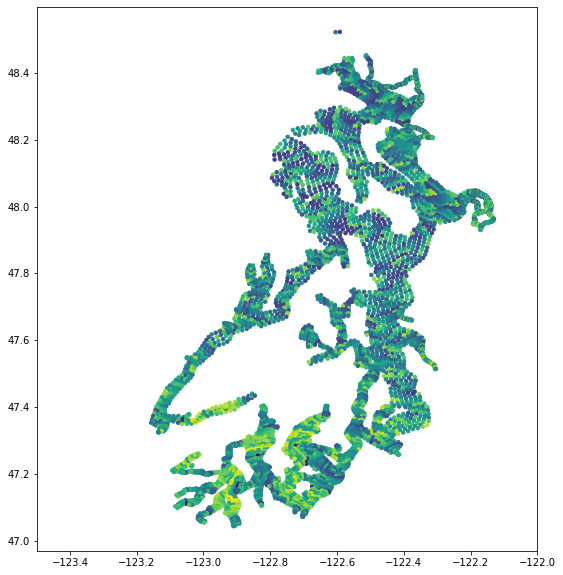

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x=df_coords_merged['lon'], 
            y=df_coords_merged['lat'], 
            c=df_coords_merged['DO'],
            s=12
           )
ax.set_aspect('equal',adjustable='box')#plt.axis('equal')
plt.xlim([-123.5,-122])
plt.show()